# Basic Evalscripts

This notebook will give you an interactive overview of how to use evalscripts. It should give you all the tools to make your own evalscripts.

To go through this notebook you will need some prior knowledge.

- [Basic Knowledge of Remote Sensing](https://university.planet.com/introduction-to-remote-sensing)
  - Sensors
  - Spectral Bands
  - Indices
- [Basic Familiarity with Sentinel Hub](https://www.sentinel-hub.com/explore/education/webinars/)
  - Collections
  - Processing API
  - Statistical API
- Basic knowledge of programming concepts
  - [functions](https://www.w3schools.com/js/js_functions.asp)
  - [variables](https://www.w3schools.com/js/js_variables.asp)
  - [arrays](https://www.w3schools.com/js/js_arrays.asp)
  - [objects](https://www.w3schools.com/js/js_objects.asp)

If you are aware of the basics of all of these topics you are well equipped to tackle this notebook. First let's dive in to some basics about evalscripts.

## Introduction to Evalscripts

What are evalscripts? Evalscripts are snippets of code which in the Sentinel Hub Infrastructure allow you to go from raw data stores (for example BYOC Collections) to visualized data.

If you think about a PlanetScope collection for example, it has a bunch of spectral bands like `blue`, `green`, `red` and `nir`. There's lots of different ways this data can be displayed or returned. You could only return the raw values of a single band, you could return a true color image or you could calculate the NDVI and return that. Together with the request body of a processing API request, the evalscript is the major part which allows you to select what exactly should be returned.

## When to use evalscripts

Evalscripts make computations on your data in the cloud possible. This makes data handling much more efficient since only the data you truly need will be returned to you. Evalscripts are often used to:

- Visualize a band or composite with specific colormaps
- Perform complex band calculations
- Combine multiple data sources into new insights
- Create cloud free composites
- Carry out multi-temporal analysis

## When not to use evalscripts

There's not many things that evalscripts can't do, since they support the full javascript language. However due to how evalscripts are structured it is only possible to do calculations on a per pixel basis. So if you need to return data which takes the neighboring pixels into account like calculating the Slope of a DEM, this unfortunately is not possible using an evalscript.

You also can't train machine learning models directly in an evalscript. However you can bring some Machine Learning models to an evalscript and predict values directly in the evalscript. [See here for an example](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bare_soil_detector/).

## Structure of an evalscript

The most basic structure of an evalscript is made up of two functions `setup()` and `evaluatePixel()`. Let's see how those two functions look like:

```js
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {bands: 3}
   };
}

function evaluatePixel(samples) {
   return [samples.red, samples.green, samples.blue]
}
```

The setup function takes care of supplying some of the necessary metadata on what kind of data will be requested and returned. Here we can see that it specifies which spectral bands should be requested. These are the bands you need in the `evaluatePixel` function to carry out your computation. In the setup function it is also specified how many bands will be returned by the `evaluatePixel` function. The setup function is implicitly called before any calcuations are taking place.

The `evaluatePixel` function will get values passed into it. The first parameter of the function holds the actual values of the data in the raw data store that you are requesting. In this case it is a [javascript object](https://www.w3schools.com/js/js_objects.asp) which has the requested bands as keys and the corresponding data as values. It is important to note that `samples` will only ever hold the values for a single Pixel. So the `evaluatePixel` function has to be specified in such a way that it works for every pixel which will be requested. In this example the samples object could look like this:

```
{"red": 9864, "green": 9536, "blue": 9472}
```

In our case we are returning the red, green and blue Band to do a true color visualization. Let's try this evalscript out and see what it returns: 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
)

config = SHConfig()

Since we will be doing quite a few requests where only the evalscript is different we will define a small helper function that takes in an evalscript as a parameter and returns the output of the request:

In [73]:
def request_helper(evalscript, date="2023-04-23"):
    aoi = Geometry(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [-52.307067, -27.262221],
                    [-52.307067, -27.238987],
                    [-52.280803, -27.238987],
                    [-52.280803, -27.262221],
                    [-52.307067, -27.262221],
                ]
            ],
        },
        CRS.WGS84,
    )
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(
                    "28eef896-9632-4546-a99e-cea34d74b21e"
                ),
                time_interval=(date, date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=aoi,
        size=[1000, 1000],
        config=config,
    )
    return request.get_data()

Now we can request data with our evalscript:

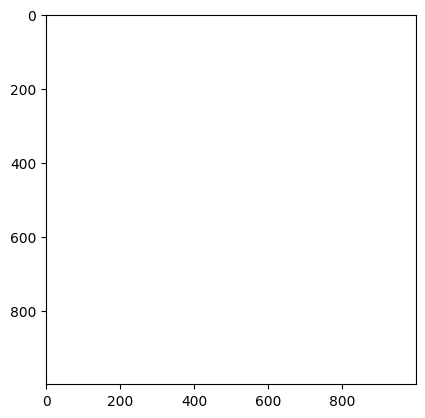

In [63]:
true_color_evalscript = """
function setup() {
    return {
        input: ["red", "green", "blue"],
        output: {bands: 3}
    };
}

function evaluatePixel(samples) {
    return [samples.red, samples.green, samples.blue]
}
"""
tc_output = request_helper(true_color_evalscript)
plt.imshow(tc_output[0]);

As you can clearly see this did not work how we expected it to, we get a fully white image back, both the minimum and maximum are 255.

In [54]:
print("Min value: ", np.min(tc_output[0]), "\nMax value: ", np.max(tc_output[0]))

Min value:  255 
Max value:  255


This is a very common gotcha when using evalscripts. It has to do with the default values which are set in the `setup` function. So to clarify what just happened here let's have a look at the default value for `sampleType`:

## Sample Type

Aside from the number of returned bands, the setup function also specifies which sample type the returned values should have. The variable `sampleType` is defined under output:

```js
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}
```

The requested sample type can be the standard types, like INT8, INT16 or FLOAT32. But the default value is `AUTO`. This custom sample type stretches reflectances (float numbers between 0-1) to UINT8 numbers (0-255) which are necessary to build images like PNGs and JPEGs. If you would like an introduction to sample types and more detail, have a look at [this](https://medium.com/sentinel-hub/sampletype-whats-all-the-fuss-about-d7348b4de647) blog post.

The `AUTO` sample type is very handy if your data source is delivered as reflectances (0-1) and you are only interested in visualizing the data, for example through a WMS service. In our case however the PlanetScope data is not delivered as reflectances, instead it is delivered as Digital Numbers (DN). DNs are reflectances with a scaling factor applied. In this case the scaling factor is 10000, which means that to get to reflectances, the values need to be divided by 10000. This is the reason why we only get 255 returned. The sample Type `AUTO` will convert everything larger than 1 into 255.

To fix this while using `AUTO` as sample type we can just divide all values by 10000 to get the correct reflectances:

```js
function evaluatePixel(samples) {
   let scale = 10000;
   return [samples.red/scale, samples.green/scale, samples.blue/scale]
}
```

So let's try what this looks like:

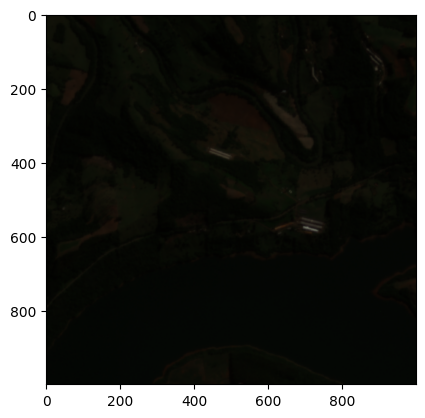

In [64]:
scaled_evalscript = """
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

function evaluatePixel(samples) {
   let scale = 10000;
   return [samples.red/scale, samples.green/scale, samples.blue/scale]
}
"""
scaled_output = request_helper(scaled_evalscript)
plt.imshow(scaled_output[0]);

Much better! We can now actually see some values, however the whole image is still quite dark. To fix that we can apply a gain to brighten up the image. A gain is usually applied by multiplying the reflectance by some value. In our case instead of multiplying the DN value, we can also divide the scale factor. You can try it yourself in the next cell. In the variable `gain` try to input different values and see what it does to the image:

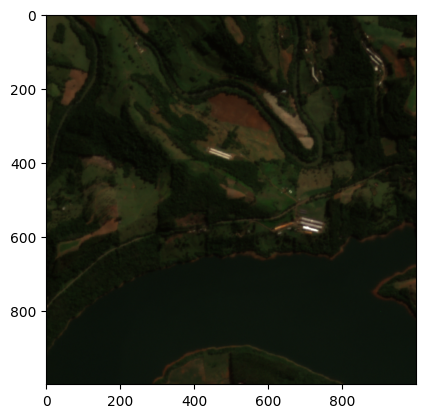

In [65]:
gain_evalscript = """
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

function evaluatePixel(samples) {
   let gain = 3;
   let scale = 10000/gain;
   return [samples.red/scale, samples.green/scale, samples.blue/scale]
}
"""
gain_output = request_helper(gain_evalscript)
plt.imshow(gain_output[0]);

### Exercise: Returning raw values

Finally it is time to write an evalscript yourself. Instead of visualizing the raw data as RGB values in a range from 0-255 we now want to return the raw values for the three bands. Try to do this yourself. A hint: Raw PlanetScope data is stored in `UINT16`.

If you are stuck you can also have a look at the solution below.


#### Excursion: Common evalscript issues

Since in these exercises you might run into issues, here's a list of common issues to check:

<table>
   <thead>
      <tr>
         <th style="width:15%">To check</th>
         <th style="width:15%">Symptoms</th>
         <th>Problem</th>
         <th>Fix</th>
      </tr>
   </thead>
<tbody>
<tr>
<td>Do you return an array in the `evaluatePixel` function?</td>
<td>

- Failure to evaluate the script
- Can in some cases be a cryptic error

</td>
<td>

```js
function evaluatePixel(samples) {
  return samples.red
}
```

</td>
<td>

```js
function evaluatePixel(samples) {
  return [samples.red]
}
```

</td>
</tr>
<tr>
<td>Are all bands which you use in <code>evaluatePixel</code> also requested in the input of the setup function?</td>
<td>

- All black output
- Colors are completely off
- Result of calculated index is all NaN

</td>
<td>

```js
function setup() {
   return {
       input: ["red", "green"], // Issue!
       output: {bands: 3}
   };
}

function evaluatePixel(samples) {
   return [samples.red, samples.green, samples.blue]
}
```

</td>
<td>

```js
function setup() {
   return {
       input: ["red", "green", "blue"], // Add all bands
       output: {bands: 3}
   };
}

function evaluatePixel(samples) {
   return [samples.red, samples.green, samples.blue]
}
```

</td>
</tr>
<tr>
<td>Does the length of the array returned in <code>evaluatePixel</code> match the number of bands specified in the output of the setup function?</td>
<td>

- Image is grayscale instead of in color
- Returned tiff does not have all the bands it should have

</td>
<td>

```js
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {bands: 1} // Issue!
   };
}

function evaluatePixel(samples) {
   return [samples.red, samples.green, samples.blue]
}
```

</td>
<td>

```js
function setup() {
   return {
       input: ["red", "green", "blue"],
       // Config number of output bands
       output: {bands: 3} 
   };
}

function evaluatePixel(samples) {
   return [samples.red, samples.green, samples.blue]
}
```

</td>
</tr>

<tr>
<td>Does the <code>sampleType</code> fit the data you are returning?</td>
<td>

- Image is all white (255) or all black (0)
- Values are not scaled how you expect them to be

</td>
<td>

```js
function setup() {
   return {
       input: ["red", "Nir"],
       // Issue, no sampleType specified!
       output: {bands: 1} 
   };
}

function evaluatePixel(samples) {
   return [index(samples.Nir, sample.red)]
}
```

</td>
<td>

```js
function setup() {
   return {
       input: ["red", "Nir"],
       output: {
         bands: 1,
         // Correct sampleType for index (-1,1)
         sampleType: "FLOAT32" 
      } 
   };
}

function evaluatePixel(samples) {
   return [index(samples.Nir, sample.red)]
}
```

</td>
</tr>

</tbody>
</table>

You can also return values during the processing by using `throw new Error()`. For example 

```js
function evaluatePixel(samples) {
   throw new Error(JSON.stringify(samples))
}
```

will return the passed in samples in the error statement of the request.

In [ ]:
raw_evalscript = """

"""
raw_output = request_helper(raw_evalscript)

# Testing if the raw data is how it should be
assert raw_output[0].max() == 3152
assert raw_output[0].min() == 130

plt.imshow(raw_output[0] / 3000);

<details><summary>See solution</summary>

```js
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {
          bands: 3,
          sampleType: "UINT16"
       }
   };
}

function evaluatePixel(samples) {
   return [samples.red, samples.green, samples.blue]
}
```
</details>


## Computation in evalscripts

We already did some very light computation in the previous evalscripts, applying the scale factor and gain to our output. Another very common calculation which is often carried out is the calculation of a remote sensing index like the Normalized Difference Vegetation Index (NDVI). Let's have a look at how this is done in an evalscript.

The first step is to request all the necessary bands. In our case this is Nir and red. We also need to update our output dictionary, the number of bands has to be one and the sample type FLOAT32, since raw NDVI data is saved as a floating point number. The set up should then look like this:

```js
function setup() {
   return {
       input: ["red", "Nir"],
       output: {
          bands: 1,
          sampleType: "FLOAT32"
       }
   };
}
```

Now in the `evaluatePixel` function we need to calculate the NDVI and return it. For this we have two options. The first one is to write down the formula ourselves:

```js
const ndvi = (samples.Nir - samples.red) / (samples.Nir + samples.red);
```

The other option is to use the helper function available called `index()`. This has two advantages, it makes the code a bit simpler and also takes care of the edge case, where the NIR and red values equal 0 in the dividend, which might lead to errors.

```js
const ndvi = index(samples.Nir, samples.red);
```

Let's try it:

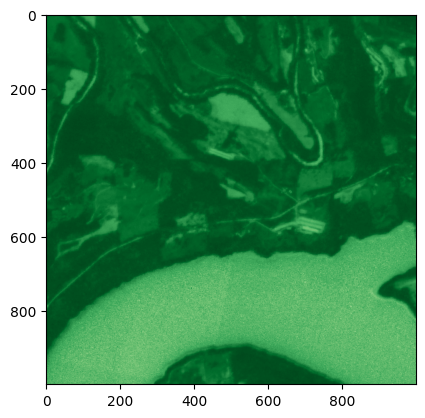

In [67]:
ndvi_raw_evalscript = """
function setup() {
   return {
       input: ["red", "nir"],
       output: {
          bands: 1,
          sampleType: "FLOAT32"
       }
   };
}

function evaluatePixel(samples) {
   const ndvi = index(samples.nir, samples.red);
   return [ndvi]
}
"""
ndvi_raw = request_helper(ndvi_raw_evalscript)
plt.imshow(ndvi_raw[0], cmap="Greens");

This gives us a nice output of raw NDVI values.

However what we have also seen in the previous section, is that there are often two use cases which require a bit of a different approach in the evalscript. There is the need for requesting analytical data, so getting the raw values. Another very frequent use cases is the need to visualize results on the fly using WMS services or similar. 

## Streaming results with evalscripts

To stream data, Sentinel Hub offers WMS/WMTS services. WMS and WMTS can only return pictures of data, but not the raw data itself. This means, that most often the output type is PNG or JPG with 3 bands corresponding to RGB. The RGB bands have to be in UINT8 (from 0-255).

In our case we return only one band (NDVI) that can not be interpreted as an RGB color as is. It also isn't in UINT8 but FLOAT32 and it doesn't range from 0-255, but from -1 to 1.

Because of this, if we want to visualize our NDVI using WMS services, we need to color encode our raw single band data.

### Visualizing

This can easily be done with the helper functions `ColorRampVisualizer` and `ColorMapVisualizer`. Both use a color map, which maps raw values to RGB colors. The Ramp Visualizer interpolates between those colors, basically creating a continuous gradient between the defined colors. This is used for continuous variables, like our NDVI. The color map visualizer does not do any interpolation and is used mainly for discrete values, like classifications.

So in our case, let's visualize NDVI going from purple at -1, over white at 0, to green at +1:

```js
const colorMap = [
  [-1, 0x8e0152],
  [0, 0xffffff],
  [1, 0x276419],
];

const visualizer = new ColorRampVisualizer(colorMap);
```

We can then use this visualizer to visualize our raw values:

```js
visualizer.process(ndvi)
```

This will return 3 values between 0-1 which can be stretched to UINT8 RGB values using the `AUTO` sampleType. Also notice that in the setup function we have to change the number of output bands from 1 to 3. Let's test it: 

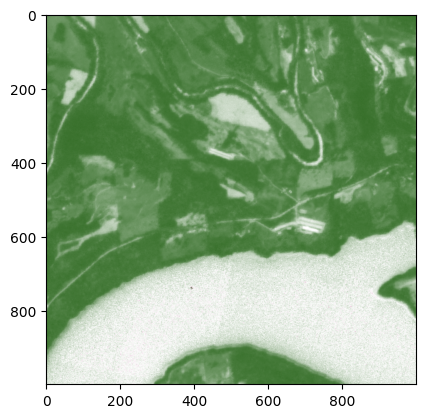

In [68]:
ndvi_visualized_evalscript = """
function setup() {
   return {
       input: ["red", "nir"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

const ramp = [
  [-1, 0x8e0152],
  [0, 0xffffff],
  [1, 0x276419],
];

const visualizer = new ColorRampVisualizer(ramp);

function evaluatePixel(samples) {
   const ndvi = index(samples.nir, samples.red);
   return visualizer.process(ndvi)
}
"""
ndvi_vis = request_helper(ndvi_visualized_evalscript)
plt.imshow(ndvi_vis[0]);

In the end this looks very similar to what we had before, however this script can be used for streaming data with WMS, while the other can not be used for that.

To summarize: When requesting raw data, use an appropriate `sampleType` and return the data directly. When using an WMS service to stream data you need to visualize the data using one of the available visualizers.

### Exercise

For an exercise you can try this yourself now. Try to adjust the evalscript, so that it returns the Normalized Difference Water Index (NDWI). It is defined as $\frac{green-nir}{green+nir}$. Also adjust the visualization so that it returns everything larger than 0.5 as blue and everything smaller than 0.5 as red. You can use [colorbrewer](https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=11) to get a good color ramp.

<details><summary>See solution</summary>

Raw:

```js
function setup() {
   return {
       input: ["green", "nir"],
       output: {
          bands: 1,
          sampleType: "FLOAT32"
       }
   };
}

function evaluatePixel(samples) {
   const ndwi = index(samples.green, samples.nir);
   return [ndwi]
}
```

Vis: 

```js
function setup() {
   return {
       input: ["green", "nir"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

const ramp = [
  [-1, 0x67001f],
  [0, 0xffffff],
  [1, 0x053061],
];

const visualizer = new ColorRampVisualizer(ramp);

function evaluatePixel(samples) {
   const ndwi = index(samples.green, samples.nir);
   return visualizer.process(ndwi)
}
```
</details>

In [ ]:
ndwi_raw_evalscript = """

"""
ndwi_raw = request_helper(ndwi_raw_evalscript)
plt.imshow(ndwi_raw[0], cmap="Blues");

In [ ]:
ndwi_visualized_evalscript = """

"""
ndwi_vis = request_helper(ndwi_visualized_evalscript)
plt.imshow(ndwi_vis[0]);

Now, let's change the date and have a look at an image which shows some common inconveniences when working with optical satellite data in general. 

# Dealing with clouds and missing data

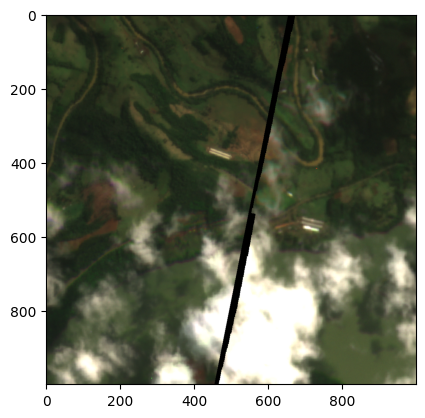

In [75]:
true_color_evalscript = """
function setup() {
   return {
       input: ["red", "green", "blue"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

function evaluatePixel(samples) {
   let gain = 3;
   let scale = 10000/gain;
   return [samples.red/scale, samples.green/scale, samples.blue/scale]
}
"""
tc_output = request_helper(true_color_evalscript, date="2022-09-03")
plt.imshow(tc_output[0]);

Here we can see that we are right on the edge of two acquisitions that don't quite overlap. This doesn't happen very often, but when it happens it is marked by a diagonal sliver of missing data over the area of interest. What we also see here is that we have some clouds covering our area of interest. But let's deal with these problems one by one:

## Missing data and Transparency

Sentinel Hub deals with missing data by providing you with a generated data layer called `dataMask`. This layer will return 1 for all pixels which have valid data (this also includes clouds), and it returns 0 for everything which is either outside of a satellite tile, or is marked as No Data in the collection. In our case the sliver in between the two acquisitions is simply not covered by any satellite takes, so it will return 0 in the data mask. Let's have a look:

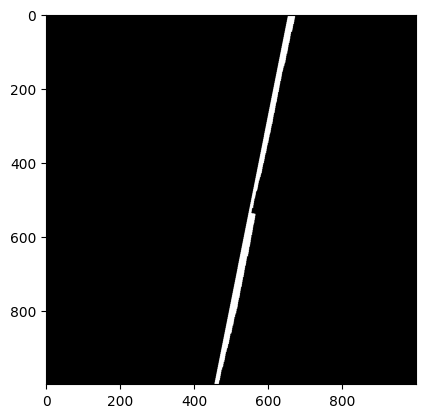

In [77]:
datamask_evalscript = """
function setup() {
   return {
       input: ["green", "dataMask"],
       output: {
          bands: 1,
          sampleType: "UINT8"
       }
   };
}

function evaluatePixel(samples) {
   return [samples.dataMask]
}
"""
datamask_output = request_helper(datamask_evalscript, date="2022-09-03")
plt.imshow(datamask_output[0], cmap="Greys");

This is exactly what we see here. Everything black is one and everything white is 0. Requested values like green and NIR where the dataMask is 0 will also all be zero. So if we would calculate the NDVI on this image it would return data, but in the sliver in the middle it wouldn't be actual data from the satellite, but all zeros which were filled by Sentinel Hub. This is why missing data like this needs to be handled.

To do this, we again have two options depending on if we want to return raw data, or visualize data using a WMS service. Let's go through them:

### Returning masked raw values

In this case we can check the dataMask and return a No Data value if the datamask is not 1:

```js
if(!samples.dataMask){
    return [NaN]
}
```

this chunk of code checks if the dataMask is not true (i.e. not one) if that is the case, it will return NaN. Be aware that NaN can only be returned with the sampleType `FLOAT32`. For an INT sample type, a no data value has to be assigned. A utility to help with that is the key `nodataValue` in the output part of the setup function. When returning a tiff this will set the appropriate nodataValue in the tiffs metadata.

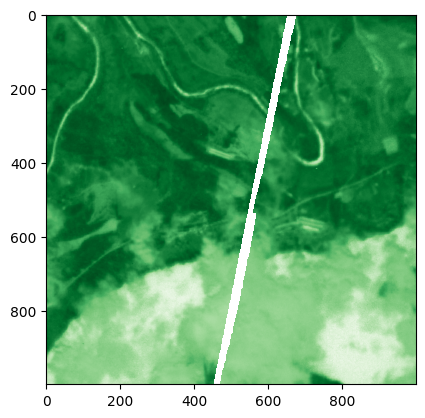

In [16]:
raw_datamask_evalscript = """
function setup() {
   return {
       input: ["red", "nir", "dataMask"],
       output: {
          bands: 1,
          sampleType: "FLOAT32",
          nodataValue: NaN
       }
   };
}

function evaluatePixel(samples) {
   if(!samples.dataMask){
      return [NaN]
   }
   const ndvi = index(samples.nir, samples.red);
   return [ndvi]
}
"""
raw_datamask_output = request_helper(raw_datamask_evalscript, date="2022-09-03")
plt.imshow(raw_datamask_output[0], cmap="Greens");

Let's check if there's actually no data there:

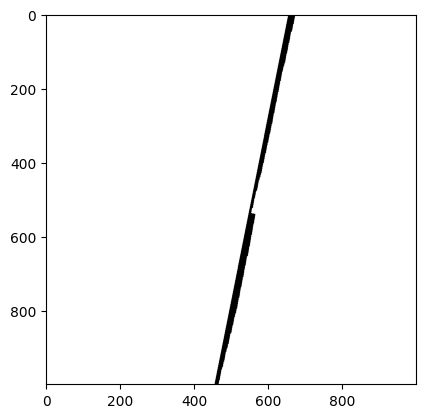

In [83]:
ndvi_nan = np.isnan(raw_datamask_output[0])
plt.imshow(ndvi_nan, cmap="Greys");

This confirms that everything we tried to set to NaN in the script, actually is NaN in the output we received.

Now let's look at how we can do this when returning visualized data.

### Transparency and WMS 

Since WMS is returning images, we can take advantage of the different bands of images. In the case of PNGs, they can be 3 band: Red, Green, Blue, (RGB) or 4 band: Red, Green, Blue, Alpha (RGBA). The 4th alpha band will determine the transparency of each pixel. From 0: completely transparent to 255: completely visible.

Because of this, we can use the 4th band to set pixels without available data to completely transparent. Here we can take advantage of the fact that using the sampleType `AUTO` and the standard mapping of the datamask of 0 for no data and 1 for available data will correspond exactly to the behaviour we want. We just have to append the dataMask band directly as the 4th returned band.

```js
return visualizer.process(ndvi).concat(samples.dataMask)
```

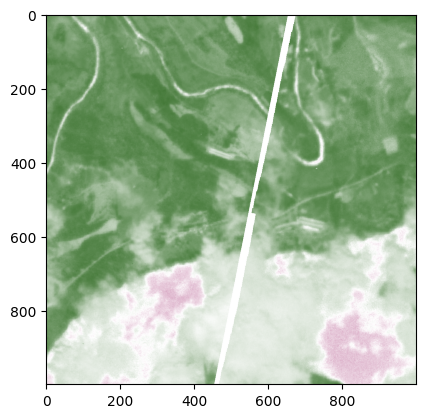

In [17]:
transparent_visualized_evalscript = """
function setup() {
   return {
       input: ["red", "nir", "dataMask"],
       output: {
          bands: 4,
          sampleType: "AUTO"
       }
   };
}

const ramp = [
  [-1, 0x8e0152],
  [0, 0xffffff],
  [1, 0x276419],
];

const visualizer = new ColorRampVisualizer(ramp);

function evaluatePixel(samples) {
   const ndvi = index(samples.nir, samples.red);
   return visualizer.process(ndvi).concat(samples.dataMask)
}
"""
transparent_vis = request_helper(transparent_visualized_evalscript, date="2022-09-03")
plt.imshow(transparent_vis[0]);

If we look only at the 4th returned band, which is our alpha band, we can see that it does properly set the opacity for the sliver of no data values that we have:

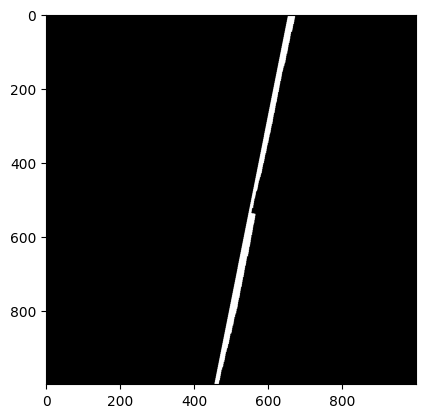

In [96]:
plt.imshow(transparent_vis[0][:, :, -1], cmap="Greys");

## Exercise: Mask clouds 

Finally let's look at the issue of clouds. Planet Scope data also comes with its own quality masks. See [here](https://docs.sentinel-hub.com/api/latest/data/planet/planet-scope/#available-bands-and-data) for a full list of what is available.

To mask clouds, cloud shadows etc as well, we can use the band `clear`, which is structured very similarly to the `dataMask` input. It returns 1 for all pixels which are clear pixels, and 0 for all pixels which are cloud, cloud shadow, haze...

The task is to exclude all pixels with missing data, but also all pixels which aren't clear. The same logic as before applies, but now both masks have to evaluate to 1, for the pixel to get included into the output. Hint: This can be handled by a logical AND operator which is `&&` in javascript (has data AND is clear) or with inverted logic the logical OR operator `||` (no data OR not clear).

<details><summary>See solution</summary>

Raw:

```js
function setup() {
   return {
       input: ["red", "nir", "clear", "dataMask"],
       output: {
          bands: 1,
          sampleType: "FLOAT32",
          nodataValue: NaN
       }
   };
}

function evaluatePixel(samples) {
   if(!samples.dataMask || !samples.clear){
      return [NaN]
   }
   const ndvi = index(samples.nir, samples.red);
   return [ndvi]
}
```

Vis: 

```js
function setup() {
   return {
       input: ["red", "nir", "clear", "dataMask"],
       output: {
          bands: 4,
          sampleType: "AUTO"
       }
   };
}

const ramp = [
  [-1, 0x8e0152],
  [0, 0xffffff],
  [1, 0x276419],
];

const visualizer = new ColorRampVisualizer(ramp);

function evaluatePixel(samples) {
   const ndvi = index(samples.nir, samples.red);
   const allClear = samples.dataMask && samples.clear;
   return visualizer.process(ndvi).concat(allClear)
}
```
</details>

In [ ]:
cloud_raw_evalscript = """

"""
cloud_raw_output = request_helper(cloud_raw_evalscript, date="2022-09-03")
plt.imshow(cloud_raw_output[0], cmap="Greens");

In [ ]:
masked_vis_evalscript = """

"""
masked_vis = request_helper(masked_vis_evalscript, date="2022-09-03")
plt.imshow(masked_vis[0]);

# Summary

In this notebook we've learned how to construct basic non-temporal evalscripts using the `setup` and `evaluatePixel` function. We've learned about `sampleType`s and that depending on the use-case the evalscript has to be structured in certain ways.

For streaming visualizations, RGB(A) images need to be returned. For analytics, the raw values can be returned immediately.

We've learned how Sentinel Hub deals with missing data (using the `dataMask` output) and how we can assign no data values to our output when doing analytic work or set pixels transparent when streaming data visualizations.

We've also learned about common issues to check when our evalscripts don't return the expected output and how to throw errors to help with debugging.

Do keep in mind that this intro does not cover a few other conecepts, like [evalscripts for statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/), [multiple outputs](https://docs.sentinel-hub.com/api/latest/evalscript/v3/#returns) in evalscripts or [returning custom userdata](https://docs.sentinel-hub.com/api/latest/evalscript/v3/#outputmetadata) in the script. See the full documentation which covers everything for these concepts.

Next, we can learn about how multi-temporal evalscripts work on Sentinel Hub.

## Further reading

- [Optimizing evalscripts](https://medium.com/sentinel-hub/custom-scripts-faster-cheaper-better-83f73894658a)
- [Collection of evalscripts](https://custom-scripts.sentinel-hub.com/)
- [Multi-temporal evalscripts](https://medium.com/sentinel-hub/multi-temporal-processing-6a80e5c84188)
- [Color correction with JavaScript](https://medium.com/sentinel-hub/color-correction-with-javascript-d721e12a919)
- [Blog post about Sample Types](https://medium.com/sentinel-hub/sampletype-whats-all-the-fuss-about-d7348b4de647)